In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import InceptionV3
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
img_height = 224
img_width = 224
batch_size = 256

In [3]:
train_directory = "/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/dataset/Espectrogramas/smote/ns=32_sol=0.9_off_f=0-40"

In [4]:
# Dividir el set en entrenamiento y validación
train_ds, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123, 
    validation_split=0.2, subset='both')

Found 8966 files belonging to 3 classes.
Using 7173 files for training.
Using 1793 files for validation.


2024-02-08 13:57:41.418081: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-08 13:57:41.418105: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-08 13:57:41.418107: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-08 13:57:41.418222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-08 13:57:41.418237: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
test_directory = "/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/dataset/Espectrogramas/multibalance_para_test/ns=32_sol=0.9_off_f=0-40"
test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', batch_size=batch_size, image_size=(img_height, img_width), seed=123)

Found 11008 files belonging to 3 classes.


In [6]:
# Esta parte se usa para generar datos para pruebas. Si se tienen datos específicos para las pruebas, se deben llamar con el nombre de test_ds
'''num_elements = len(train_ds)

porcentaje_test = 0.1
train_size = int((1-porcentaje_test) * num_elements)


test_size = num_elements - train_size
test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)'''

'num_elements = len(train_ds)\n\nporcentaje_test = 0.1\ntrain_size = int((1-porcentaje_test) * num_elements)\n\n\ntest_size = num_elements - train_size\ntest_ds = train_ds.take(test_size)\ntrain_ds = train_ds.skip(test_size)'

In [7]:
class_names = train_ds.class_names
print(class_names)

['LP', 'VLP', 'VT']


In [8]:
'''y_train = train_ds.map(lambda _, label: label).unbatch()
y_train = list(y_train.as_numpy_iterator())
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)'''

"y_train = train_ds.map(lambda _, label: label).unbatch()\ny_train = list(y_train.as_numpy_iterator())\nclass_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)\nclass_weight_dict = dict(enumerate(class_weights))\nprint(class_weight_dict)"

# Modelo DenseNet 121

In [9]:
num_classes = len(class_names)

In [10]:
# Cargar la arquitectura preentrenada VGG16 sin las capas superiores (sin incluir la capa de salida)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)) #input_shape=(altura, anchura, canales))
base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

In [11]:
# Congelar las capas de la base (no se entrenarán durante el ajuste fino)
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Agregar capas personalizadas a la arquitectura base
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.000001), activity_regularizer=regularizers.L2(0.000001)),
    #layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [13]:
# Definir la programación de la tasa de aprendizaje exponencial
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=len(train_ds)*10,
    decay_rate=0.9
)

In [14]:
# Crear un optimizador con la programación de la tasa de aprendizaje exponencial y momentum
custom_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

In [15]:
# Compilar el modelo
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# Entrenar el modelo
epochs = 100

history = model.fit(train_ds, epochs=epochs, validation_data=validation_dataset)#, class_weight=class_weight_dict)

Epoch 1/100


2024-02-08 13:57:44.459181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - ETA: 0s - loss: 2.2055 - accuracy: 0.7060

2024-02-08 13:58:27.042267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 54s 2s/step - loss: 2.2055 - accuracy: 0.7060 - val_loss: 3.6791 - val_accuracy: 0.6235
Epoch 2/100
29/29 [==============================] - 52s 2s/step - loss: 1.4135 - accuracy: 0.7999 - val_loss: 1.3115 - val_accuracy: 0.7942
Epoch 3/100
29/29 [==============================] - 52s 2s/step - loss: 0.7241 - accuracy: 0.8683 - val_loss: 0.9075 - val_accuracy: 0.8054
Epoch 4/100
29/29 [==============================] - 52s 2s/step - loss: 0.5803 - accuracy: 0.8775 - val_loss: 0.8964 - val_accuracy: 0.8226
Epoch 5/100
29/29 [==============================] - 53s 2s/step - loss: 0.4583 - accuracy: 0.9065 - val_loss: 0.5215 - val_accuracy: 0.8940
Epoch 6/100
29/29 [==============================] - 52s 2s/step - loss: 0.4737 - accuracy: 0.8963 - val_loss: 0.8587 - val_accuracy: 0.8215
Epoch 7/100
29/29 [==============================] - 52s 2s/step - loss: 0.4641 - accuracy: 0.9016 - val_loss: 0.4303 - val_accuracy: 0.8996
Epoch 8/100
29/29 [======

In [17]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_ds)
print(f'Precisión en el conjunto de prueba: {test_acc}')

43/43 [==============================] - 64s 1s/step - loss: 0.1999 - accuracy: 0.9556
Precisión en el conjunto de prueba: 0.9555777311325073


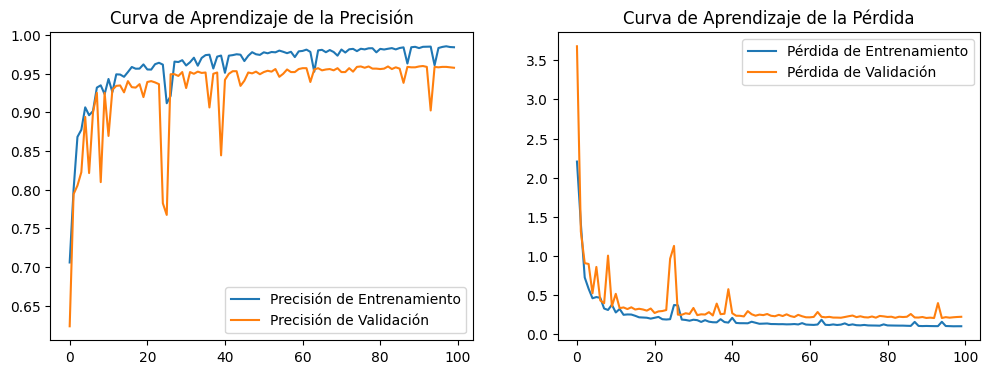

In [18]:
# Trazar la curva de aprendizaje
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Curva de Aprendizaje de la Precisión')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Curva de Aprendizaje de la Pérdida')
plt.show()

In [19]:
ruta_modelos_entrenados = '/Volumes/SSD_ANDRÉS/Modelos entrenados'

In [20]:
model.save(ruta_modelos_entrenados+'/Inception_RegOpt_224_bs256NDO_L2000001L2000001_decay10epoc')

INFO:tensorflow:Assets written to: /Volumes/SSD_ANDRÉS/Modelos entrenados/Inception_RegOpt_224_bs256NDO_L2000001L2000001_decay10epoc/assets


INFO:tensorflow:Assets written to: /Volumes/SSD_ANDRÉS/Modelos entrenados/Inception_RegOpt_224_bs256NDO_L2000001L2000001_decay10epoc/assets


In [21]:
ruta_modelos_entrenados = '/Volumes/SSD_ANDRÉS/Modelos entrenados'
new_model = tf.keras.models.load_model(ruta_modelos_entrenados+'/Inception_RegOpt_224_bs256NDO_L2000001L2000001_decay10epoc')
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   #print("Label: ",label_batch)
   y_true.append(label_batch)
   # compute predictions
   #print("Imagen: ",image_batch)
   preds = new_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))
   #print("-----------------")

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2024-02-08 15:25:48.754690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 165ms/step


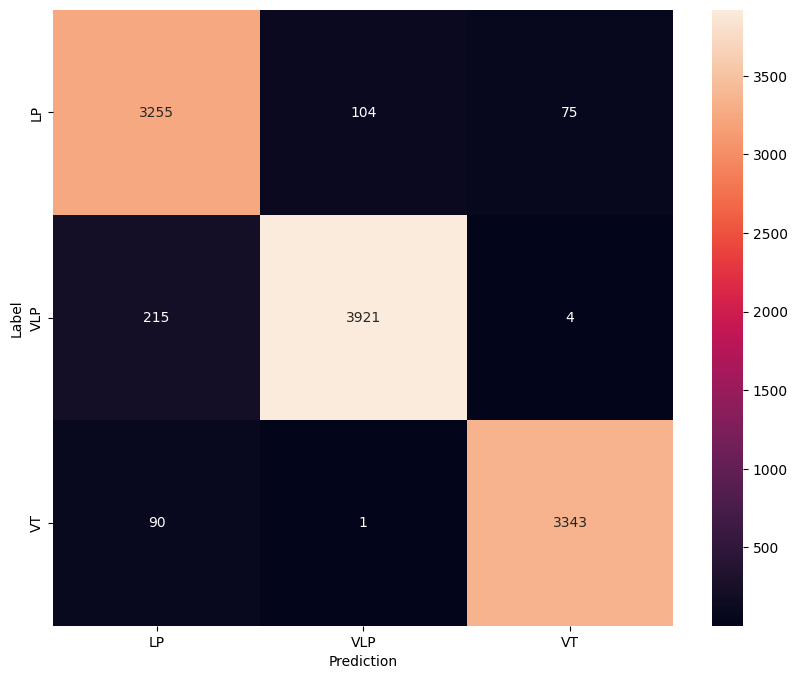

In [22]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [23]:
cm = confusion_matrix(correct_labels, predicted_labels)
print('%LP: '+str(cm[0][0]/sum(cm[0]) * 100))
print('%VLP: '+str(cm[1][1]/sum(cm[1]) * 100))
print('%VT: '+str(cm[2][2]/sum(cm[2]) * 100))

%LP: 94.78741991846243
%VLP: 94.71014492753623
%VT: 97.35002912055911


In [24]:
from sklearn.metrics import classification_report
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3434
           1       0.97      0.95      0.96      4140
           2       0.98      0.97      0.98      3434

    accuracy                           0.96     11008
   macro avg       0.96      0.96      0.96     11008
weighted avg       0.96      0.96      0.96     11008

